# 1. **Importing Libraries and Setting Config**

In [1]:
# The basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# All things torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler

# Transformers and other utilities
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
import os
from tqdm import tqdm

In [2]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("microsoft/deberta-v3-base")  # DebertaV2ForModel
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
model

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): StableDropout()
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0): DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): StableDropout()
            (dropout): StableDropout()
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): StableDropout()
          )
        )
        (intermediate): Deb

In [15]:
CONFIG = {
    'batch_size': 8, 
    'epochs': 7, 
    'lr': 2e-5,
    'n_accumulate': 8, # For Gradient Accumulation
    'pretrained_model_path': 'microsoft/deberta-v3-base',
    'weight_decay': 1e-6,
    'seed': 2022,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'patience': 3, # For early stopping
    'saved_model_path': "saved_model_state_deberta.pt" # To save best model weights for inference.
}

# 2. Data Preparation and EDA

> ### **Read Data and Fetch and clean essay texts from directory.**

In [8]:
data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')

def fetch_essay_texts(df, train=True):
    if train:
        base_path = './input/train/'
    else:
        base_path = './input/test/'
        
    essay_texts = {}
    for filename in os.listdir(base_path):
        with open(base_path + filename) as f:
            text = f.readlines()
            full_text = ' '.join([x for x in text])
            essay_text = ' '.join([x for x in full_text.split()])
        essay_texts[filename[:-4]] = essay_text
    df['essay_text'] = [essay_texts[essay_id] for essay_id in df['essay_id'].values]   
    return df
    
data = fetch_essay_texts(data)
data

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,Some people may ask multiple people for advice...
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,Some people may ask multiple people for advice...


> ### **Distribution of Target - Discourse Effectiveness and Discourse Type variables.**

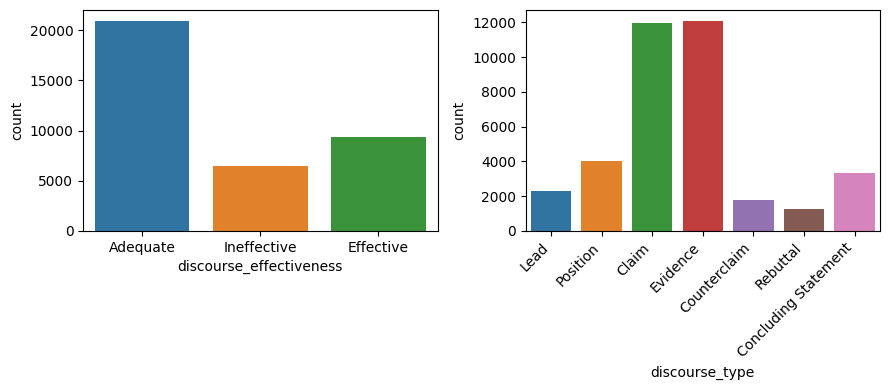

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
# Distribution of target labels - discourse effectiveness
sns.countplot(x = data['discourse_effectiveness'], ax=ax[0])
# Distribution of discourse types
plot = sns.countplot(x = data['discourse_type'], ax=ax[1])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.tight_layout()

> ### **Distribution of discourse types by target**

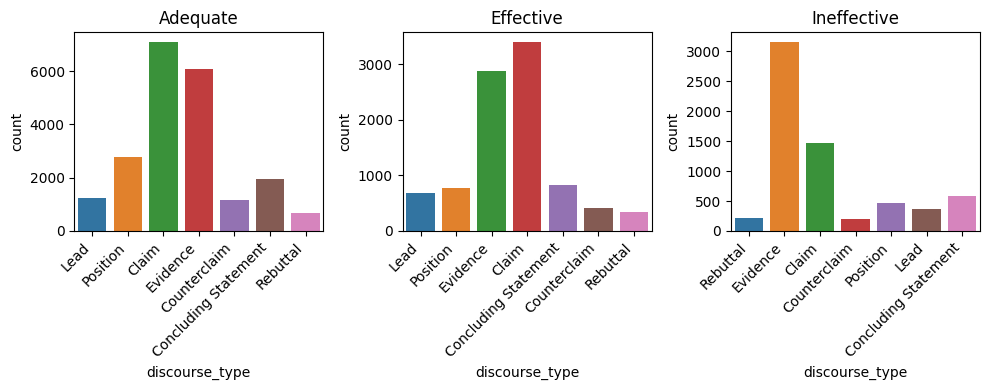

In [10]:
# Distribution of discourse types by target label.
fig, ax = plt.subplots(1, 3, figsize=(10,4))
for idx, label in enumerate(np.unique(data['discourse_effectiveness'])):
    plot = sns.countplot(x=data[data['discourse_effectiveness'] == label]['discourse_type'], ax=ax[idx])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[idx].set_title(label)
fig.tight_layout()


In [11]:
# Encode target variable and create train-val split
label_dict = {'Effective': 0, 'Adequate': 1, 'Ineffective': 2}
data['discourse_effectiveness'].replace(label_dict, inplace=True)
data.drop(['discourse_id', 'essay_id'], axis=1, inplace=True)
train_data, val_data = train_test_split(data, random_state=42, train_size=0.9)

> ### **Setting seeds for reproducibility of results**
#### Useful Link: [CUDA Determinism](https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking)

In [12]:
def set_seed(seed=CONFIG['seed']):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# 3. Torch Essentials - Dataset, DataLoader and Model

*  #### The custom **dataset** class inherits from the torch.utils.data.Dataset class and MUST contain the __len__ and __getitem__ methods in addition to the constructor. 
* #### __len__ returns the total number of observations, while __getitem__ fetches the required data from a specified index - this is usually the tokenized output required for training the model and is accessed through the DataLoader.
* #### For the Siamese training approach, we create two sentences and tokenize them separately. 
    #### 1. Sentence A: discourse_type + [SEP] + discourse_text
    #### 2. Sentence B: essay text

In [13]:
class FeedbackDataset(Dataset):
    def __init__(self, tokenizer, essay_text, discourse_type, discourse_text, effectiveness):
        self.essay_text = essay_text
        self.discourse_type = discourse_type
        self.discourse_text = discourse_text
        self.target = effectiveness
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.discourse_text)
    
    def __getitem__(self, idx):
        # Sentence A
        input_discourse = self.discourse_type[idx] + ' ' + self.tokenizer.sep_token + ' ' + self.discourse_text[idx]
        tokenized_discourse = self.tokenizer.encode_plus(
                            input_discourse,
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=512,
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt'
                        )
        # Sentence B
        tokenized_essay = self.tokenizer.encode_plus(
                            self.essay_text[idx],
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=512,
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt',
                        )
        return {
            'discourse_input_ids': tokenized_discourse['input_ids'].flatten(),
            'discourse_attention_mask': tokenized_discourse['attention_mask'].flatten(),
            'essay_input_ids': tokenized_essay['input_ids'].flatten(),
            'essay_attention_mask': tokenized_essay['attention_mask'].flatten(),
            'target': self.target[idx]
        }

* #### Create instances of above Dataset class for train and val data, and pass these to their respective DataLoaders. 
* #### The DataLoader batches and returns the samples in the same format as return type of the __getitem__ method (dict here).
* #### Take a look at the example batch below - a dict with the same keys specified in the __getitem__ method, with *batch_size* number of samples bunched together to create 2D tensors of ids and masks.

In [16]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG['pretrained_model_path'])
train_dataset = FeedbackDataset(tokenizer, 
                                train_data['essay_text'].values,
                                train_data['discourse_type'].values, 
                                train_data['discourse_text'].values, 
                                train_data['discourse_effectiveness'].values)
val_dataset = FeedbackDataset(tokenizer, 
                              val_data['essay_text'].values,
                              val_data['discourse_type'].values, 
                              val_data['discourse_text'].values, 
                              val_data['discourse_effectiveness'].values)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, pin_memory=True)

# Sample training batch.
next(iter(train_dataloader))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'discourse_input_ids': tensor([[     1,  18172,      2,  ...,      0,      0,      0],
         [     1,  12993,      2,  ...,      0,      0,      0],
         [     1,  21049,      2,  ...,      0,      0,      0],
         ...,
         [     1,  21049,      2,  ...,      0,      0,      0],
         [     1,  21049,      2,  ...,      0,      0,      0],
         [     1, 103967,  11652,  ...,      0,      0,      0]]),
 'discourse_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'essay_input_ids': tensor([[    1,   593,   610,  ...,     0,     0,     0],
         [    1,   307, 13351,  ...,   400,   310,     2],
         [    1, 10147,   945,  ...,   262,   370,     2],
         ...,
         [    1, 10147,   945,  ...,     0,     0,     0],
         [    1,   333,   274,  ...,     0,     

### Understanding the Pooling Layer - why it is needed:

* #### The pretrained layer of any BERT-type architecture returns mainly 2 useful outputs - the last hidden state and pooled output.
* #### The last hidden state contains the 768-dimension (for base) **hidden state vector for each token for each sequence in the batch.** Let's say we have a batch size of 8, with each sequence padded to a max_length of 512. The last hidden state then returns a 3D - (8, 512, 768) size tensor.
* #### On the contrary, the pooled output contains the **hidden state vector of only the first token of every sequence in the batch.** Thus, making it a 2D - (8, 768) size tensor with the above example.
* #### Now, the pooled output can be used directly for downstream finetuning, but with just the embeddings of the 1st tokens of sequences, we might be losing out on a fair amount of data. Instead, we could use the last hidden state output as it does contain embeddings for each token of the sequence. But these token embedding vectors will need to be meaningfully aggregated to obtain a similar 2D tensor by condensing along dim=1.
* #### We could simply average all the token embeddings of each sequence, but remember we also have special tokens like [PAD], whose embeddings aren't useful. Hence, we make use of this custom **MeanPooling Layer**, to average out only the useful token embeddings using the attention_mask.

### So, HOW does this MeanPooling work?
* #### As discussed, we will use the attention mask to filter out embeddings of special tokens from the average.
* #### First, we unsqueeze each attention scalar into a single element vector: 0 -> [0] and 1 -> [1], followed by expanding it to the hidden state size (768). Now, we have our 2D attention mask in the same 3D size as the *last hidden state*.
* #### Next, perform an element-wise multiplication of the 2 tensors thereby reducing the entire hidden state vector of all special tokens to zeroes.
* #### To perform the average, sum up the token embedding vectors of each sequence after the above product and divide the whole thing with the summed up token attention mask vectors of the sequence. The final output will be of size (*batch_size*, *hidden_dim*).

In [17]:
class MeanPoolingLayer(nn.Module):
    def __init__(self):
        super(MeanPoolingLayer, self).__init__()
    
    def forward(self, last_hidden_state, attention_mask):
        expanded_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        mask_sum = expanded_mask.sum(1)
        mask_sum = torch.clamp(mask_sum, min=1e-9)
        masked_hidden_state = torch.sum(last_hidden_state * expanded_mask, 1)
        return masked_hidden_state / mask_sum

### The Siamese Model Architecture: 
* #### Train two separate BERT-heads for sentence A and B as defined earlier. Obtain the last hidden states and perform mean pooling to get two indepedent 2D tensors of (batch_size, hidden_dim). Lets call them u, v.
* #### Now, concatenate u, v, abs(u-v) horizontally into a size of (batch_size, 3*hidden_dim)
* #### Proceed with the standard Dropout and Fully Connected Layer to obtain logits for all 3 classes.

In [20]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.pretrained_layer = AutoModel.from_pretrained(CONFIG['pretrained_model_path'])
        self.pooler = MeanPoolingLayer()
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(3*self.pretrained_layer.config.hidden_size, num_classes)
    
    def forward(self, discourse_input_ids, discourse_attention_mask, essay_input_ids, essay_attention_mask):
        # Sentence A - BERT + mean pooling
        discourse_out = self.pretrained_layer(input_ids=discourse_input_ids, attention_mask=discourse_attention_mask)
        discourse_emb = self.pooler(discourse_out.last_hidden_state, discourse_attention_mask)
        # Sentence B - BERT + mean pooling
        essay_out = self.pretrained_layer(input_ids=essay_input_ids, attention_mask=essay_attention_mask)
        essay_emb = self.pooler(essay_out.last_hidden_state, essay_attention_mask)
        # concat
        concat_emb = torch.cat([discourse_emb, essay_emb, torch.abs(essay_emb - discourse_emb)], dim=-1)
        x = self.dropout(concat_emb)
        x = self.fc(x)
        return x
        

* #### Instantiate the model and push to cuda, same with loss function. 
* #### The competition metric (multiclass logloss) is essentially same as the categorical crossentropy loss.

In [21]:
model = CustomModel().to(CONFIG['device'])
optimizer = AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
loss = nn.CrossEntropyLoss().to(CONFIG['device'])

def eval_metric(ground_truths, probs):
    logloss = 0
    for i in range(len(ground_truths)):
        logloss += np.log(probs[i][ground_truths[i]].item())
    
    return (-1/len(ground_truths)) * logloss
        

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 4. Model Training and Validation

* #### Here we use techniques such as Gradient Accumulation and Mixed Precision Training.
* #### The model parameter update (optimizer.step()) is performed not for every batch as is usually the case, but after *n_accumulate* number of batches. This helps mimic a larger batch size.


In [22]:
def train_loop(model, dataloader, loss, optimizer):
    model.train()
    batch_losses = []
    scaler = torch.cuda.amp.GradScaler()
    # Iterate over each batch.
    for batch_num, batch in tqdm(enumerate(dataloader)):
        discourse_input_ids = batch['discourse_input_ids'].to(CONFIG['device'], non_blocking=True)
        discourse_attention_mask = batch['discourse_attention_mask'].to(CONFIG['device'], non_blocking=True)
        essay_input_ids = batch['essay_input_ids'].to(CONFIG['device'], non_blocking=True)
        essay_attention_mask = batch['essay_attention_mask'].to(CONFIG['device'], non_blocking=True)
        targets = batch['target'].to(CONFIG['device'], non_blocking=True)
        # Mixed Precision Training, only for forward prop.
        with torch.cuda.amp.autocast():
            logits = model(discourse_input_ids, discourse_attention_mask, essay_input_ids, essay_attention_mask)
            probs = nn.Softmax(dim=1)(logits)
        # Remember, Crossentropy Loss requires logits and not probabilities
        batch_loss = loss(logits, targets)
        batch_loss = batch_loss / CONFIG['n_accumulate']
        batch_losses.append(batch_loss.item())
        # Backpropagation
        scaler.scale(batch_loss).backward()
        if (batch_num+1) % CONFIG['n_accumulate'] == 0:
            # Updating model parameters
            scaler.step(optimizer)
            scaler.update()
            # Setting gradients to None instead of zero.
            optimizer.zero_grad(set_to_none=True)
    
    return np.mean(batch_losses)
        

In [23]:
def validation_loop(model, loss, dataloader):
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            discourse_input_ids = batch['discourse_input_ids'].to(CONFIG['device'], non_blocking=True)
            discourse_attention_mask = batch['discourse_attention_mask'].to(CONFIG['device'], non_blocking=True)
            essay_input_ids = batch['essay_input_ids'].to(CONFIG['device'], non_blocking=True)
            essay_attention_mask = batch['essay_attention_mask'].to(CONFIG['device'], non_blocking=True)
            targets = batch['target'].to(CONFIG['device'], non_blocking=True)
            with torch.cuda.amp.autocast():
                logits = model(discourse_input_ids, discourse_attention_mask, essay_input_ids, essay_attention_mask)
                probs = nn.Softmax(dim=1)(logits)
            batch_loss = loss(logits, targets)
            batch_losses.append(batch_loss.item())
    
    return np.mean(batch_losses)

* #### Run the training and validation loops for every epoch and obtain the mean loss for the epoch.
* #### To avoid using an overfit model, employ Early Stopping callback to abort training if the validation loss doesn't reduce for *patience* no. of epochs at a stretch.
* #### Save the model weights corresponding to best (min) loss value in a .pt file for future inference. Keeps overwriting if better losses are encountered.

In [24]:
history = defaultdict(list)
best_loss = np.inf
prev_loss = np.inf
earlystop_trigger = 0
epochs = CONFIG['epochs']
print('Training Start ......')
for epoch in range(CONFIG['epochs']):
    print(f'Epoch {epoch+1} of {epochs}')
    train_loss = train_loop(model, train_dataloader, loss, optimizer)
    print(f'Training Loss: {train_loss}')
    val_loss = validation_loop(model, loss, val_dataloader)
    print(f'Val Loss: {val_loss}')
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if val_loss <= prev_loss:
        earlystop_trigger = 0
    else:
        earlystop_trigger += 1
        if earlystop_trigger >= CONFIG['patience']:
            print(f'Early Stopping Triggered after {epoch+1} epochs. Aborting Training...')
            break
    if val_loss < best_loss:
        print(f'New best val loss, saving model checkpoint at epoch {epoch+1}.')
        torch.save(model.state_dict(), CONFIG['saved_model_path'])
        best_loss = val_loss
    prev_loss = val_loss

Training Start ......
Epoch 1 of 7


4136it [1:06:32,  1.04it/s]


Training Loss: 0.08975135611381015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [02:37<00:00,  2.92it/s]


Val Loss: 0.6312396505604619
New best val loss, saving model checkpoint at epoch 1.
Epoch 2 of 7


4136it [1:06:41,  1.03it/s]


Training Loss: 0.07361663840494949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [02:37<00:00,  2.92it/s]


Val Loss: 0.6243798297384511
New best val loss, saving model checkpoint at epoch 2.
Epoch 3 of 7


4136it [1:07:40,  1.02it/s]


Training Loss: 0.06376066152546807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [02:36<00:00,  2.93it/s]


Val Loss: 0.5917098335597826
New best val loss, saving model checkpoint at epoch 3.
Epoch 4 of 7


4136it [1:31:12,  1.32s/it]


Training Loss: 0.05265938520892676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [03:33<00:00,  2.15it/s]


Val Loss: 0.627040431810462
Epoch 5 of 7


4136it [1:20:15,  1.16s/it]


Training Loss: 0.039587892462252645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [03:09<00:00,  2.43it/s]


Val Loss: 0.713797030241593
Epoch 6 of 7


4136it [1:20:15,  1.16s/it]


Training Loss: 0.027360737439050434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [03:05<00:00,  2.48it/s]

Val Loss: 0.8434442768926206
Early Stopping Triggered after 6 epochs. Aborting Training...


#### Plot loss diagnostic curves with losses obtained above. Observe, how the validation loss begins to rise after an initial decline, a clear indication of overfitting. The saved model weights correspond to the epoch with validation loss minima on this graph.

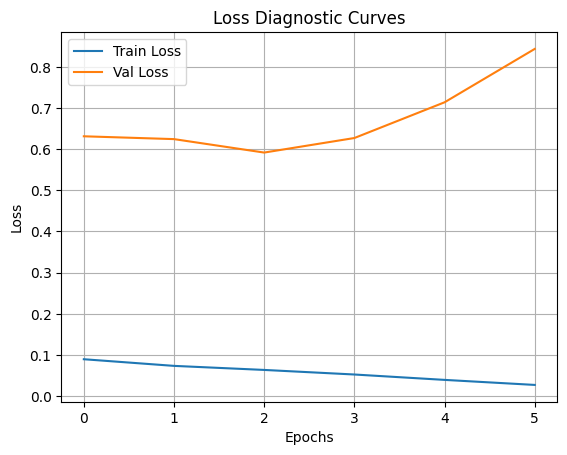

In [25]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Diagnostic Curves')
plt.show()

CONFIG### Model Inference

In [32]:
@torch.no_grad()
def inference(essay_text, discourse_type, discourse_text, model):
    model.eval()
    input_discourse = discourse_type + ' ' + tokenizer.sep_token + ' ' + discourse_text
    tokenized_discourse = tokenizer.encode_plus(
        input_discourse,
        return_token_type_ids=False,
        return_attention_mask=True,
        max_length=512,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='pt'
    )
    tokenized_essay = tokenizer.encode_plus(
                            essay_text,
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=512,
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt',
                        )
    discourse_input_ids = tokenized_discourse['input_ids'].to(CONFIG['device'], non_blocking=True)
    discourse_attention_mask = tokenized_discourse['attention_mask'].to(CONFIG['device'], non_blocking=True)
    essay_input_ids = tokenized_essay['input_ids'].to(CONFIG['device'], non_blocking=True)
    essay_attention_mask = tokenized_essay['attention_mask'].to(CONFIG['device'], non_blocking=True)
    with torch.cuda.amp.autocast():
        logits = model(discourse_input_ids, discourse_attention_mask, essay_input_ids, essay_attention_mask)
        probs = nn.Softmax(dim=1)(logits)
    return probs

In [40]:
def fetch_essay_texts(df, train=True):
    if train:
        base_path = './input/train/'
    else:
        base_path = './input/test/'
        
    essay_texts = {}
    for filename in os.listdir(base_path):
        with open(base_path + filename) as f:
            text = f.readlines()
            full_text = ' '.join([x for x in text])
            essay_text = ' '.join([x for x in full_text.split()])
        essay_texts[filename[:-4]] = essay_text
    df['essay_text'] = [essay_texts[essay_id] for essay_id in df['essay_id'].values]   
    return df

In [41]:
test_data = pd.read_csv('./input/test.csv')
test_data = fetch_essay_texts(test_data, train=False)
tokenizer = AutoTokenizer.from_pretrained(CONFIG['pretrained_model_path'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
df = pd.DataFrame()
df['discourse_id'] = test_data['discourse_id']
class0, class1, class2 = [], [], []
model = CustomModel().to(CONFIG['device'])
model.load_state_dict(torch.load(CONFIG['saved_model_path']))
for essay_text, discourse_type, discourse_text in zip(test_data['essay_text'].tolist(), test_data['discourse_type'].tolist(), test_data['discourse_text'].tolist()):
    probs = inference(essay_text, discourse_type, discourse_text, model)
    class0.append(probs[0][0].item())
    class1.append(probs[0][1].item())
    class2.append(probs[0][2].item())
    
df['Ineffective'] = class2
df['Adequate'] = class1
df['Effective'] = class0
df.to_csv('submission.csv', index=False)
df

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.005587,0.751370,0.243042
1,5a88900e7dc1,0.010512,0.918906,0.070582
2,9790d835736b,0.013944,0.643584,0.342473
3,75ce6d68b67b,0.023443,0.666624,0.309933
4,93578d946723,0.021312,0.590832,0.387856
5,2e214524dbe3,0.017345,0.749878,0.232777
6,84812fc2ab9f,0.003983,0.367957,0.628060
7,c668ff840720,0.007269,0.461281,0.531450
8,739a6d00f44a,0.048557,0.835019,0.116424
9,bcfae2c9a244,0.006551,0.829940,0.163510
